<a href="https://colab.research.google.com/github/AbdullahHemada/Vision_project/blob/main/_final_fer_2013_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cell loads the `fer2013` dataset from KaggleHub and stores its path.

In [1]:
import kagglehub
path = kagglehub.dataset_download("msambare/fer2013")

Using Colab cache for faster access to the 'fer2013' dataset.


In [2]:
# import libraries
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization #for CNN model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix  #for training report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential   #for training model
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import cv2
import os
from keras.regularizers import l2
from keras.layers import Activation
from keras.models import Model
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import MaxPool2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model



#Visualizing Data


This cell defines the file paths for the training and testing datasets based on the previously loaded KaggleHub path.

In [3]:
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')

Existing Classes : ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


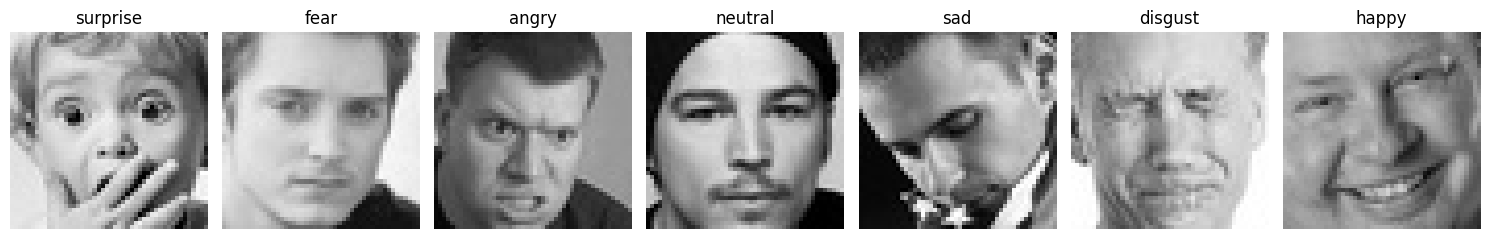

train_counts: 



,Train Count
surprise,3171
fear,4097
angry,3995
neutral,4965
sad,4830
disgust,436
happy,7215



test_counts:


,Test Count
surprise,831
fear,1024
angry,958
neutral,1233
sad,1247
disgust,111
happy,1774


total train image : 28709
total test image : 7178


In [4]:
classes=os.listdir(train_path)
print("Existing Classes :",classes)

plt.figure(figsize=(15,5))
for index,emotion in enumerate(classes):
  emotion_path=os.path.join(train_path,emotion)
  rand_image=random.choice(os.listdir(emotion_path))
  image_path=os.path.join(emotion_path,rand_image)
  image=cv2.imread(image_path)
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  plt.subplot(1, len(classes), index+1)
  plt.imshow(img)
  plt.title(emotion)
  plt.axis("off")

plt.tight_layout()
plt.show()


# Function to count images per class in a given path
def count_images_per_class(base_path, classes):
    counts = {}
    for emotion in classes:
        emotion_dir = os.path.join(base_path, emotion)
        if os.path.exists(emotion_dir):
            counts[emotion] = len(os.listdir(emotion_dir))
        else:
            counts[emotion] = 0
    return counts

# Count images for training set
train_counts = count_images_per_class(train_path, classes)
train_df = pd.DataFrame.from_dict(train_counts, orient='index', columns=['Train Count'])

# Count images for testing set
test_counts = count_images_per_class(test_path, classes)
test_df = pd.DataFrame.from_dict(test_counts, orient='index', columns=['Test Count'])

# Display the summary in a formatted way
print("train_counts: \n")
display(train_df)
print("\ntest_counts:")
display(test_df)

print("total train image :",train_df['Train Count'].sum())
print("total test image :",test_df['Test Count'].sum())

# Images shape

In [5]:
print(f"Image dimensions: {img.shape}") # Output from the previously executed cell


Image dimensions: (48, 48, 3)


### Dataset Class Distribution Visualization

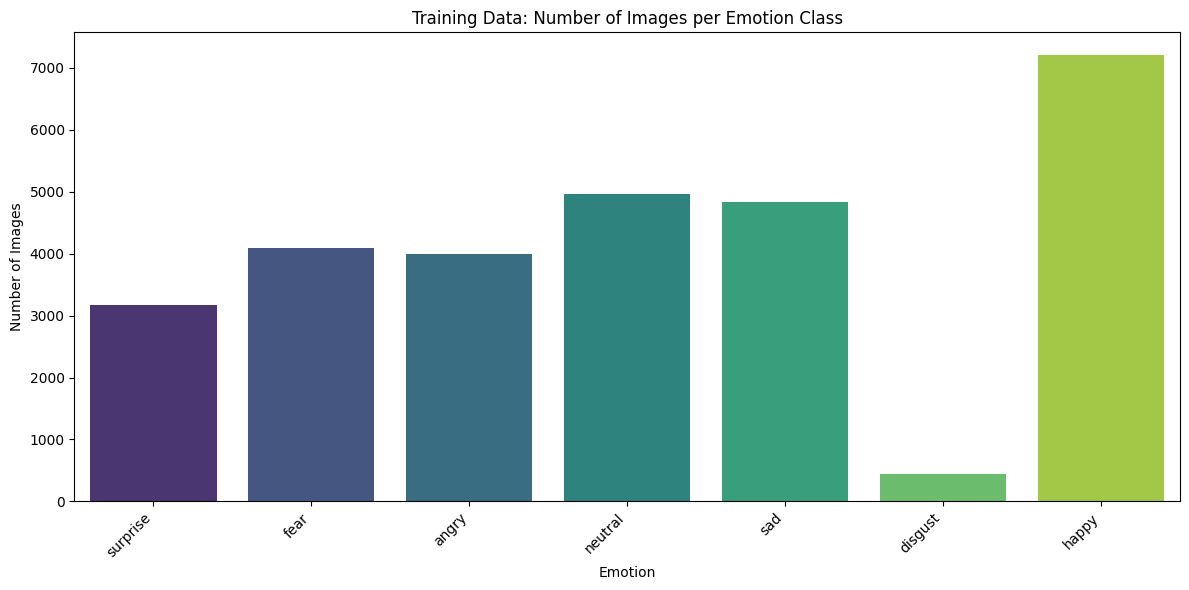

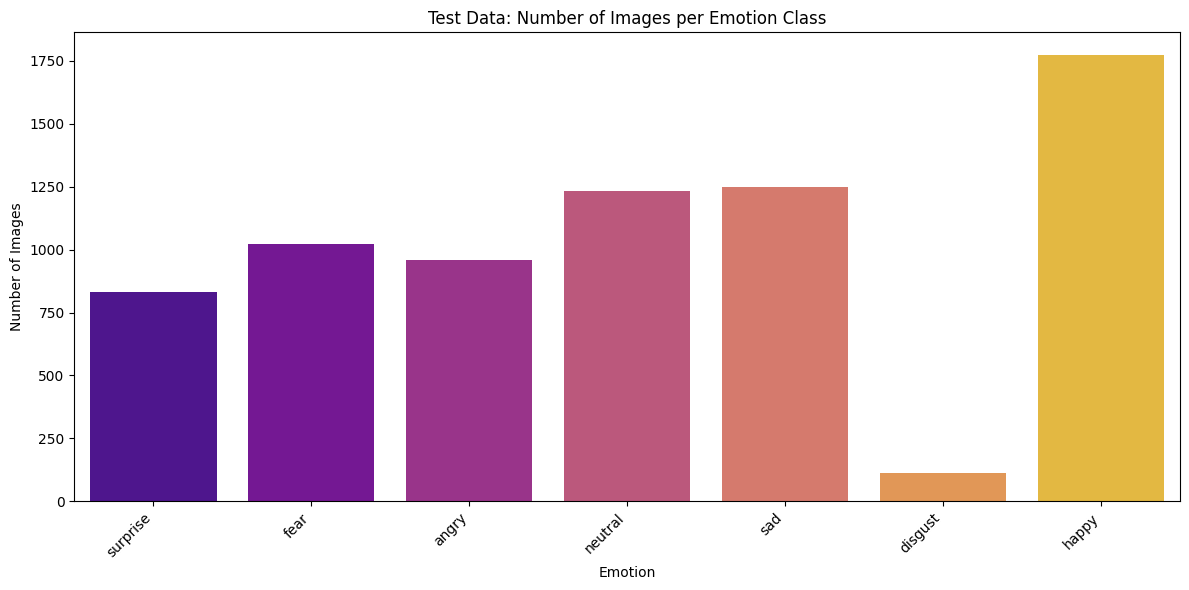

In [6]:
# Visualize class distribution for training set
plt.figure(figsize=(12, 6))
sns.barplot(x=train_df.index, y='Train Count', data=train_df, palette='viridis', hue=train_df.index, legend=False)
plt.title('Training Data: Number of Images per Emotion Class')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualize class distribution for testing set
plt.figure(figsize=(12, 6))
sns.barplot(x=test_df.index, y='Test Count', data=test_df, palette='plasma', hue=test_df.index, legend=False)
plt.title('Test Data: Number of Images per Emotion Class')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Data Augmentation

In [7]:
# Image parameters
IMG_SIZE = (96, 96)
BATCH_SIZE = 224
EPOCHS = 100
NUM_CLASSES = 7

In [8]:
# Data generators with augmentation for trainingt
train_datagen=ImageDataGenerator(
    rescale=1./255,       #Normalization
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

In [9]:
# Data generators with Normalizing for testing
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Loading training data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 22968 images belonging to 7 classes.


In [11]:
# Loading validation data
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 5741 images belonging to 7 classes.


In [12]:
# Loading test data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    color_mode='rgb', # Changed from 'grayscale' to 'rgb'
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)

Found 7178 images belonging to 7 classes.


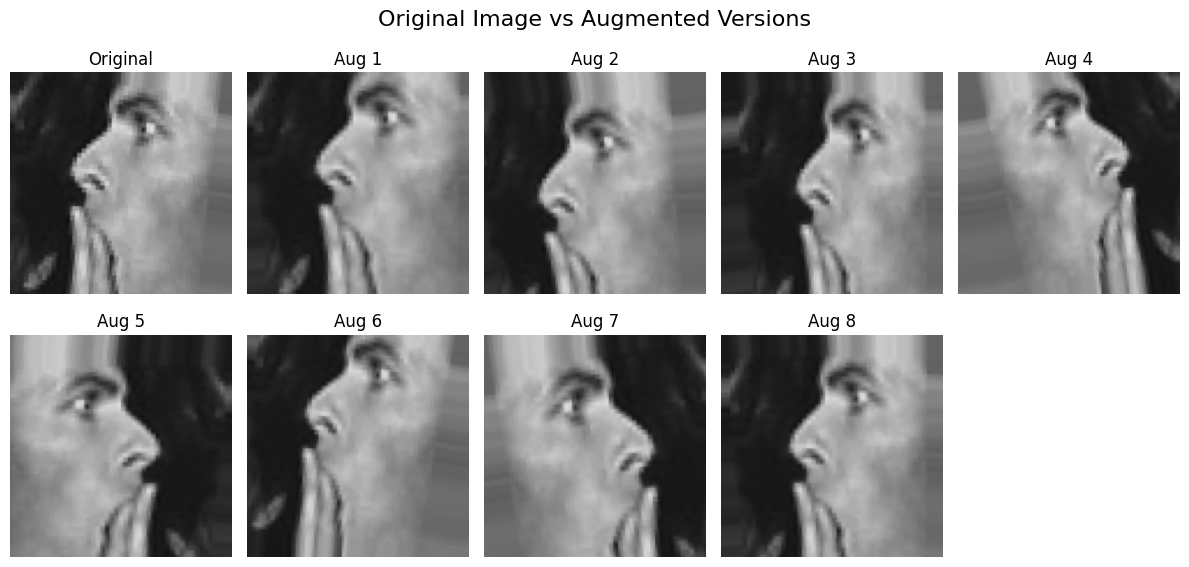

In [13]:
# Take one image
images, labels = next(train_generator)
img = images[0]

# Plot original + augmented versions
plt.figure(figsize=(12, 6))

plt.subplot(2, 5, 1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

# Show 8 augmented versions
for i in range(8):
    augmented_img = train_datagen.random_transform(img)
    plt.subplot(2, 5, i + 2)
    plt.imshow(augmented_img)
    plt.title(f"Aug {i+1}")
    plt.axis('off')

plt.suptitle("Original Image vs Augmented Versions", fontsize=16)
plt.tight_layout()
plt.show()


#Building the CNN Model

In [14]:
def build_resnet50_fer(num_classes=7):
    inputs = Input(shape=(IMG_SIZE[0],IMG_SIZE[1], 3))
    x = preprocess_input(inputs)

    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=x
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    return model

#Optimizer

In [22]:
model_Adam = build_resnet50_fer()
model_Adam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [23]:
model_SGD = build_resnet50_fer()
model_SGD.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate= 0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [24]:
model_Adagrad = build_resnet50_fer()
model_Adagrad.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate= 0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [25]:
model_Adam.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (None, 96, 96)    │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_10         │ (None, 96, 96)    │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_11         │ (None, 96, 96)    │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_3 (Stack)     │ (None, 96, 96, 3) │          0 │ get_item_9[0][0], │
│                     │                   │            │ get_item_10[0][0… │
│                     │                   │            │ get_item_11[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 96, 96, 3) │          0 │ stack_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ add_3[0][0]       │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c

 Total params: 24,640,391 (94.00 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [26]:
#early stop to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

In [27]:
# We use class weights to address class imbalance since some classes have fewer samples.

# 1. Get the class indices and counts from the training generator
class_lable=train_generator.classes
num_classes=train_generator.num_classes

# 2. Compute class weights
class_weights_array=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(class_lable),y=class_lable)

class_weights = dict(enumerate(class_weights_array))
print("Calculated Class Weights:", class_weights)

Calculated Class Weights: {0: np.float64(1.0266404434114071), 1: np.float64(9.401555464592715), 2: np.float64(1.0009587727708533), 3: np.float64(0.5684585684585685), 4: np.float64(0.826068191627104), 5: np.float64(0.8491570541259982), 6: np.float64(1.2933160650937552)}


#Model Training

In [28]:
history=model_Adam.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 107s 936ms/step - accuracy: 0.1352 - loss: 2.0635 - val_accuracy: 0.1237 - val_loss: 1.9299 - learning_rate: 0.0010
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 86s 837ms/step - accuracy: 0.1241 - loss: 1.9516 - val_accuracy: 0.1812 - val_loss: 1.9338 - learning_rate: 0.0010
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 85s 828ms/step - accuracy: 0.1371 - loss: 1.9440 - val_accuracy: 0.1094 - val_loss: 1.9621 - learning_rate: 0.0010
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 86s 837ms/step - accuracy: 0.1545 - loss: 1.9220 - val_accuracy: 0.1724 - val_loss: 1.9437 - learning_rate: 0.0010
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 86s 832ms/step - accuracy: 0.1608 - loss: 1.9494 - val_accuracy: 0.1730 - val_loss: 1.9399 - learning_rate: 0.0010
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 85s 828ms/step - accuracy: 0.1541 - loss: 1.9477 - val_accuracy: 0.1587 - val_loss: 1.9357 - learning_rate: 0.0010
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 86s 832ms/step - accur

KeyboardInterrupt: 

In [29]:
#fit model with SGD optimizer
history_SGD=model_SGD.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.1474 - loss: 2.1502 - val_accuracy: 0.1629 - val_loss: 1.9432 - learning_rate: 0.0010
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 88s 855ms/step - accuracy: 0.1440 - loss: 2.0718 - val_accuracy: 0.0341 - val_loss: 1.9546 - learning_rate: 0.0010
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 86s 837ms/step - accuracy: 0.1470 - loss: 1.9813 - val_accuracy: 0.0488 - val_loss: 1.9547 - learning_rate: 0.0010
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 86s 841ms/step - accuracy: 0.1364 - loss: 2.0152 - val_accuracy: 0.1643 - val_loss: 1.9289 - learning_rate: 0.0010
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 88s 850ms/step - accuracy: 0.1421 - loss: 2.0026 - val_accuracy: 0.1697 - val_loss: 1.9377 - learning_rate: 0.0010
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 88s 853ms/step - accuracy: 0.1474 - loss: 1.9584 - val_accuracy: 0.1000 - val_loss: 1.9541 - learning_rate: 0.0010
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 86s 835ms/step - accuracy

In [ ]:
#fit model with Adagrad optimizer
history_Adagrad=model_Adagrad.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)

#Model Evaluation

In [ ]:
# Evaluating on test set
test_loss,test_acc=model_Adam.evaluate(test_generator)
print("Test Loss:",test_loss)
print("Test Accuracy:",test_acc)

#Evaluating SGD model on test set
test_loss_SGD,test_acc_SGD=model_SGD.evaluate(test_generator)
print("SGD Test Loss:",test_loss_SGD)
print("SGD Test Accuracy:",test_acc_SGD)

# evaluating Adagrad model on test set
test_loss_Adagrad,test_acc_Adagrad=model_Adagrad.evaluate(test_generator)
print("Adagrad Test Loss:",test_loss_Adagrad)
print("Adagrad Test Accuracy:",test_acc_Adagrad)

In [ ]:
# Predictions and metrics
y_pred = model_Adam.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred_classes, target_names=train_generator.class_indices.keys()))

#Predicting and metrics for SGD model
y_pred_SGD = model_SGD.predict(test_generator)
y_pred_classes_SGD = np.argmax(y_pred_SGD, axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred_classes_SGD, target_names=train_generator.class_indices.keys()))

#Predicting and metrics for Adagrad model
y_pred_Adagrad = model_Adagrad.predict(test_generator)
y_pred_classes_Adagrad = np.argmax(y_pred_Adagrad, axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred_classes_Adagrad, target_names=train_generator.class_indices.keys()))

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [ ]:
# Plot training & validation accuracy and loss values for Adam optimizer
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


# Plot training & validation accuracy and loss values for SGD optimizer
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_SGD.history['accuracy'], label='Train Acc')
plt.plot(history_SGD.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('SGD Optimizer - Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history_SGD.history['loss'], label='Train Loss')
plt.plot(history_SGD.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('SGD Optimizer - Loss')
plt.show()

# Plot training & validation accuracy and loss values for Adagrad optimizer
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_Adagrad.history['accuracy'], label='Train Acc')
plt.plot(history_Adagrad.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Adagrad Optimizer - Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history_Adagrad.history['loss'], label='Train Loss')
plt.plot(history_Adagrad.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Adagrad Optimizer - Loss')
plt.show()

# Predictions Visualization

In [ ]:
# Visualizing correct & wrong predictions

# File paths from test generator
filenames = test_generator.filenames
n_samples = len(filenames)
n_display = 20  # Number of images to show (mix of correct and wrong)

# True labels and predictions
y_true = test_generator.classes
y_pred = np.argmax(model_Adam.predict(test_generator), axis=1)

# Correct and incorrect indices
correct_idx = np.where(y_true == y_pred)[0]
incorrect_idx = np.where(y_true != y_pred)[0]

# Shuffling & selecting some from each
np.random.shuffle(correct_idx)
np.random.shuffle(incorrect_idx)

selected_correct = correct_idx[:n_display // 2]
selected_incorrect = incorrect_idx[:min(len(incorrect_idx), n_display // 2)]

selected_idx = np.concatenate([selected_correct, selected_incorrect])
np.random.shuffle(selected_idx)

# Class names
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(15, 3 * (n_display // 5 + 1)))
for i, idx in enumerate(selected_idx[:n_display]):
    # Load image
    img_path = os.path.join(test_path, filenames[idx])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)  # Ensure same size

    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    correct = y_true[idx] == y_pred[idx]

    # Title color: green for correct, red for wrong
    color = 'green' if correct else 'red'
    title = f"True: {true_label}\nPred: {pred_label}"

    plt.subplot(n_display // 5 + 1, 5, i + 1)
    plt.imshow(img)
    plt.title(title, color=color, fontsize=10)
    plt.axis('off')

plt.suptitle("Correct (Green) vs Incorrect (Red) Predictions on Test Set", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model Adam_optimizer
model_Adam.save('Emotion_Recognition_model_Adam_optimizer.keras')
print("Model saved to Emotion Recognition_model_Adam_optimizer.keras")

# Save the trained model SGD_optimizer
model_SGD.save('Emotion_Recognition_model_SGD_optimizer.keras')
print("Model saved to Emotion Recognition_model_SGD_optimizer.keras")

# Save the trained model Adagrad_optimizer
model_Adagrad.save('Emotion_Recognition_model_Adagrad_optimizer.keras')
print("Model saved to Emotion Recognition_model_Adagrad_optimizer.keras")